In [ ]:
!nvidia-smi
!pip install -q einops

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Wed Jul 16 05:15:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%writefile AquaMorphicNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim):
        super().__init__()
        self.attn = PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head))
        self.ff = PreNorm(dim, FeedForward(dim, mlp_dim))
    def forward(self, x):
        x = self.attn(x) + x
        x = self.ff(x) + x
        return x

class PhysicsBranch(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, out_channels, 3, 1, 1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        t_map = torch.sigmoid(x[:, :3, :, :])
        a_map = torch.sigmoid(x[:, 3:, :, :])
        return t_map, a_map

class AquaMorphicNet(nn.Module):
    def __init__(self, image_size=256, patch_size=16, dim=512, depth=4, heads=8, mlp_dim=1024, channels=3):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.transformer = nn.Sequential(*[TransformerBlock(dim, heads, dim // heads, mlp_dim) for _ in range(depth)])
        self.embedding_to_patch = nn.Linear(dim, patch_dim)
        self.physics_branch = PhysicsBranch(in_channels=3, out_channels=4)

    def forward(self, img):
        p = self.patch_size
        t_map, a_map = self.physics_branch(img)

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape
        x += self.pos_embedding[:, :n]
        x = self.transformer(x)
        x = self.embedding_to_patch(x)
        restored_img = rearrange(x, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', h=img.shape[2]//p, w=img.shape[3]//p, p1=p, p2=p)

        return restored_img, t_map, a_map

Writing AquaMorphicNet.py


In [ ]:
import os
import random
import shutil
import glob

GDRIVE_UNSPLIT_DATA_PATH = "/content/drive/My Drive/datasets/UIEB"

GDRIVE_SPLIT_DATA_PATH = "/content/drive/My Drive/UIEB_SPLIT"


def split_dataset(source_dir, dest_dir, split_ratio=0.9):
    """
    Splits the UIEB dataset into training and testing sets.
    """
    print(f"Starting dataset split from '{source_dir}' to '{dest_dir}'...")

    raw_path = os.path.join(source_dir, 'raw-890')
    ref_path = os.path.join(source_dir, 'reference-890')

    if not os.path.exists(raw_path) or not os.path.exists(ref_path):
        print(f"Error: Source directories not found at {raw_path} and {ref_path}")
        print("Please make sure your unsplit UIEB data has 'raw-890' and 'reference-890' subfolders.")
        return

    # Define destination paths
    train_raw_path = os.path.join(dest_dir, 'train', 'raw')
    train_ref_path = os.path.join(dest_dir, 'train', 'reference')
    test_raw_path = os.path.join(dest_dir, 'test', 'raw')
    test_ref_path = os.path.join(dest_dir, 'test', 'reference')

    # Create destination directories
    for path in [train_raw_path, train_ref_path, test_raw_path, test_ref_path]:
        os.makedirs(path, exist_ok=True)

    # Get list of all images
    image_files = [os.path.basename(f) for f in glob.glob(os.path.join(raw_path, '*'))]
    random.shuffle(image_files)

    # Split the files
    split_index = int(len(image_files) * split_ratio)
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Copy files to new directories
    print(f"Copying {len(train_files)} images to training set...")
    for filename in train_files:
        shutil.copy(os.path.join(raw_path, filename), os.path.join(train_raw_path, filename))
        shutil.copy(os.path.join(ref_path, filename), os.path.join(train_ref_path, filename))

    print(f"Copying {len(test_files)} images to testing set...")
    for filename in test_files:
        shutil.copy(os.path.join(raw_path, filename), os.path.join(test_raw_path, filename))
        shutil.copy(os.path.join(ref_path, filename), os.path.join(test_ref_path, filename))

    print("Dataset splitting complete!")

# Run the splitting function
split_dataset(GDRIVE_UNSPLIT_DATA_PATH, GDRIVE_SPLIT_DATA_PATH)

Starting dataset split from '/content/drive/My Drive/datasets/UIEB' to '/content/drive/My Drive/UIEB_SPLIT'...
Copying 801 images to training set...
Copying 89 images to testing set...
Dataset splitting complete!


In [ ]:
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from tqdm import tqdm
import glob

# Import our model
from AquaMorphicNet import AquaMorphicNet

# --- 1. Dataset and Dataloader ---
class UIEBDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        filename = self.file_list[idx]
        underwater_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        gt_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')
        return self.transform(underwater_img), self.transform(gt_img)

# --- 2. Training Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
NUM_EPOCHS = 50
IMAGE_SIZE = 256
DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/train"
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Checkpoints"
LAMBDA_PHYSICS = 0.2

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- 3. Training Logic (No changes) ---
def train_fn(model, loader, optimizer, l1_loss, physics_loss_weight):
    loop = tqdm(loader, leave=True)
    total_loss_avg = 0
    for underwater, ground_truth in loop:
        underwater = underwater.to(DEVICE)
        ground_truth = ground_truth.to(DEVICE)
        restored, t_map, a_map = model(underwater)
        loss_recon = l1_loss(restored, ground_truth)
        a_map_3channel = a_map.repeat(1, 3, 1, 1)
        physics_reconstructed = restored * t_map + a_map_3channel * (1 - t_map)
        loss_physics = l1_loss(underwater, physics_reconstructed)
        loss = loss_recon + physics_loss_weight * loss_physics
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss_avg += loss.item()
        loop.set_postfix(L1=loss_recon.item(), Physics=loss_physics.item())
    print(f"Epoch avg loss: {total_loss_avg / len(loader)}")

# --- 4. Main Execution (MODIFIED TO LOAD model_epoch_50.pth) ---
if __name__ == "__main__":
    model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-7)
    l1_loss = nn.L1Loss()

    start_checkpoint_path = os.path.join(CHECKPOINT_DIR, "model_epoch_50.pth")
    save_checkpoint_path = os.path.join(CHECKPOINT_DIR, "model_finetuned.pth")

    if os.path.exists(start_checkpoint_path):
        print(f"Best checkpoint found! Loading weights from: {os.path.basename(start_checkpoint_path)}")
        model.load_state_dict(torch.load(start_checkpoint_path))
        print("Model weights loaded. Starting RECOVERY fine-tuning.")
    else:
        print(f"ERROR: Could not find '{os.path.basename(start_checkpoint_path)}' to start recovery.")
        # Exit if the required model is not found
        exit()

    train_dataset = UIEBDataset(root_dir=DATA_DIR, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    print(f"\nStarting recovery training for {NUM_EPOCHS} epochs with LR={LEARNING_RATE}.")
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(model, train_loader, optimizer, l1_loss, LAMBDA_PHYSICS)
        scheduler.step()
        print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.7f}")

        # Save the new fine-tuned model continuously
        torch.save(model.state_dict(), save_checkpoint_path)

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"model_finetuned_epoch_{epoch+1}.pth"))
            print(f"Checkpoint saved to {os.path.basename(save_checkpoint_path)}")

    print("\nRecovery training complete.")
    print(f"Final fine-tuned model saved as: {os.path.basename(save_checkpoint_path)}")

Writing train.py


In [ ]:
# Cell 5: Run the training script
!python train.py

--- Epoch 1/50 ---
100% 201/201 [00:47<00:00,  4.22it/s, L1=0.118, Physics=0.108]
Epoch avg loss: 0.27256094534598774
--- Epoch 2/50 ---
100% 201/201 [00:43<00:00,  4.63it/s, L1=0.0986, Physics=0.0611]
Epoch avg loss: 0.14431628392110415
--- Epoch 3/50 ---
100% 201/201 [00:44<00:00,  4.56it/s, L1=0.0879, Physics=0.0949]
Epoch avg loss: 0.12791913999846918
--- Epoch 4/50 ---
100% 201/201 [00:44<00:00,  4.51it/s, L1=0.117, Physics=0.0537]
Epoch avg loss: 0.12066497212618738
--- Epoch 5/50 ---
100% 201/201 [00:46<00:00,  4.35it/s, L1=0.199, Physics=0.146]
Epoch avg loss: 0.11512855221679555
--- Epoch 6/50 ---
100% 201/201 [00:43<00:00,  4.59it/s, L1=0.0793, Physics=0.0698]
Epoch avg loss: 0.11082093491779631
--- Epoch 7/50 ---
100% 201/201 [00:43<00:00,  4.61it/s, L1=0.0917, Physics=0.0644]
Epoch avg loss: 0.1073912659391242
--- Epoch 8/50 ---
100% 201/201 [00:44<00:00,  4.49it/s, L1=0.0801, Physics=0.0559]
Epoch avg loss: 0.1049871784611721
--- Epoch 9/50 ---
100% 201/201 [00:49<00:00,  

In [ ]:

!pip install -q scikit-image

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the model architecture
from AquaMorphicNet import AquaMorphicNet

# --- 2. Configuration (pointing to Google Drive) ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_Checkpoints/model_epoch_50.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 3. Load Model ---
model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded successfully from Google Drive.")

# --- 4. Prepare for Evaluation ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

test_raw_path = os.path.join(TEST_DATA_DIR, 'raw')
test_ref_path = os.path.join(TEST_DATA_DIR, 'reference')
test_files = sorted(glob.glob(os.path.join(test_raw_path, '*')))

psnr_scores = []
ssim_scores = []

print(f"\nStarting evaluation on {len(test_files)} test images...")

# --- 5. Evaluation Loop ---
with torch.no_grad():
    for raw_file_path in tqdm(test_files):
        filename = os.path.basename(raw_file_path)
        ref_file_path = os.path.join(test_ref_path, filename)

        # Load images
        raw_img = Image.open(raw_file_path).convert('RGB')
        ref_img = Image.open(ref_file_path).convert('RGB')

        # Prepare tensors
        input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
        gt_tensor = transform(ref_img) # Ground truth stays on CPU

        # Run model inference
        restored_tensor, _, _ = model(input_tensor)
        restored_tensor = restored_tensor.squeeze(0).cpu() # Move to CPU for metrics

        # Convert tensors to NumPy arrays for scikit-image
        # and transpose from (C, H, W) to (H, W, C)
        restored_np = np.transpose(restored_tensor.numpy(), (1, 2, 0))
        gt_np = np.transpose(gt_tensor.numpy(), (1, 2, 0))

        # Clip values to be in [0, 1] range to avoid potential precision errors
        restored_np = np.clip(restored_np, 0, 1)
        gt_np = np.clip(gt_np, 0, 1)

        # Calculate metrics
        # data_range is 1.0 because our tensors are normalized to [0, 1]
        current_psnr = psnr(gt_np, restored_np, data_range=1.0)
        # channel_axis=-1 is the new name for multichannel=True
        current_ssim = ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1)

        psnr_scores.append(current_psnr)
        ssim_scores.append(current_ssim)

# --- 6. Report Final Scores ---
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n---" + "="*25 + "---")
print("    Quantitative Evaluation Complete")
print("---" + "="*25 + "---")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print("---" + "="*25 + "---")


Model loaded successfully from Google Drive.

Starting evaluation on 89 test images...


100%|██████████| 89/89 [00:08<00:00, 10.79it/s]


---=========================---
    Quantitative Evaluation Complete
---=========================---
Average PSNR: 20.35 dB
Average SSIM: 0.6836
---=========================---


In [ ]:
# Cell to Enhance and Save all Test Images

import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import glob

# Ensure the model architecture is defined in your notebook
# If not, you'll need to run the cell that defines AquaMorphicUNet first.

# --- Configuration ---
# Load your best performing model
CHECKPOINT_DIR = "/content/drive/MyDrive/AquaMorphic_Checkpoints"
MODEL_FILENAME = "model_epoch_50.pth" # Using epoch 70 as it had the best SSIM
MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

# Source of images to enhance
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"

# Destination folder for the enhanced images
# Let's create a new folder for this
ENHANCED_IMAGE_DIR = "/content/drive/My Drive/First_Model"
os.makedirs(ENHANCED_IMAGE_DIR, exist_ok=True)

IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Model ---
model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"Model '{MODEL_FILENAME}' loaded successfully.")

# --- Define Transform ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# --- Processing Loop ---
test_files = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '*')))
print(f"Found {len(test_files)} images to enhance and save...")

with torch.no_grad():
    for raw_file_path in tqdm(test_files, desc="Enhancing and Saving Images"):
        filename = os.path.basename(raw_file_path)

        # Load and transform the image
        raw_img = Image.open(raw_file_path).convert('RGB')
        input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)

        # Run inference
        restored_tensor, _, _ = model(input_tensor)

        # Convert output tensor to a PIL Image
        restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        # Define the save path and save the image
        save_path = os.path.join(ENHANCED_IMAGE_DIR, filename)
        restored_pil.save(save_path)

print(f"\nEnhancement complete. All {len(test_files)} images are saved in:")
print(ENHANCED_IMAGE_DIR)

Using test image: /content/drive/MyDrive/UIEB_SPLIT/test/raw/19_img_.png
Model loaded successfully from Google Drive.


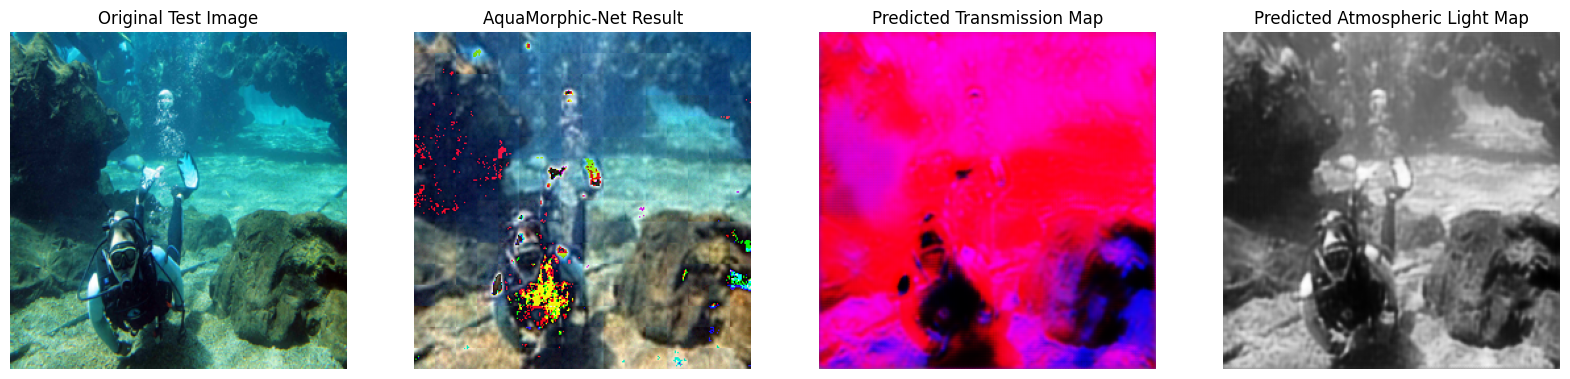

In [ ]:

import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

# Import the model architecture
from AquaMorphicNet import AquaMorphicNet

# --- Configuration (pointing to Google Drive) ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_Checkpoints/model_epoch_50.pth"
TEST_IMAGE_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Find a test image automatically
try:
    INPUT_IMAGE_PATH = "/content/drive/MyDrive/UIEB_SPLIT/test/raw/19_img_.png"#glob.glob(os.path.join(TEST_IMAGE_DIR, '*'))[0]
    print(f"Using test image: {INPUT_IMAGE_PATH}")
except IndexError:
    print(f"Error: No images found in {TEST_IMAGE_DIR}. Please check the path.")
    # Handle error, maybe by exiting or using a default
    INPUT_IMAGE_PATH = None

if INPUT_IMAGE_PATH:
    # --- Load Model ---
    model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded successfully from Google Drive.")

    # --- Image Pre-processing ---
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    # --- Run Inference ---
    input_image = Image.open(INPUT_IMAGE_PATH).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor, t_map, a_map = model(input_tensor)

    # --- Display Results ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Test Image")
    axes[0].axis('off')

    axes[1].imshow(transforms.ToPILImage()(restored_tensor.squeeze(0).cpu()))
    axes[1].set_title("AquaMorphic-Net Result")
    axes[1].axis('off')

    axes[2].imshow(transforms.ToPILImage()(t_map.squeeze(0).cpu()))
    axes[2].set_title("Predicted Transmission Map")
    axes[2].axis('off')

    axes[3].imshow(transforms.ToPILImage()(a_map.squeeze(0).cpu()), cmap='gray')
    axes[3].set_title("Predicted Atmospheric Light Map")
    axes[3].axis('off')

    plt.show()

In [ ]:
# Cell 5: Run the training script
!python train.py

Checkpoint found! Loading weights from /content/drive/My Drive/AquaMorphic_Checkpoints/model_final.pth
Model weights loaded. Fine-tuning from previous state.

Starting training for 150 epochs.
--- Epoch 1/150 ---
100% 201/201 [02:10<00:00,  1.54it/s, L1=0.208, Physics=0.0374]
Epoch avg loss: 0.14299910068882637
Current Learning Rate: 0.000100
--- Epoch 2/150 ---
100% 201/201 [00:48<00:00,  4.16it/s, L1=0.0595, Physics=0.14]
Epoch avg loss: 0.14050714438086126
Current Learning Rate: 0.000100
--- Epoch 3/150 ---
100% 201/201 [00:46<00:00,  4.30it/s, L1=0.214, Physics=0.0348]
Epoch avg loss: 0.14243001227651664
Current Learning Rate: 0.000100
--- Epoch 4/150 ---
100% 201/201 [00:48<00:00,  4.10it/s, L1=0.222, Physics=0.0645]
Epoch avg loss: 0.14062944213994108
Current Learning Rate: 0.000100
--- Epoch 5/150 ---
100% 201/201 [00:48<00:00,  4.17it/s, L1=0.177, Physics=0.0366]
Epoch avg loss: 0.14096334068781108
Current Learning Rate: 0.000100
--- Epoch 6/150 ---
100% 201/201 [00:47<00:00,  

In [ ]:
#  Quantitative Evaluation on the Entire Test Set

!pip install -q scikit-image

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the model architecture
from AquaMorphicNet import AquaMorphicNet

# --- 2. Configuration (pointing to Google Drive) ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_Checkpoints/model_final.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 3. Load Model ---
model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded successfully from Google Drive.")

# --- 4. Prepare for Evaluation ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

test_raw_path = os.path.join(TEST_DATA_DIR, 'raw')
test_ref_path = os.path.join(TEST_DATA_DIR, 'reference')
test_files = sorted(glob.glob(os.path.join(test_raw_path, '*')))

psnr_scores = []
ssim_scores = []

print(f"\nStarting evaluation on {len(test_files)} test images...")

# --- 5. Evaluation Loop ---
with torch.no_grad():
    for raw_file_path in tqdm(test_files):
        filename = os.path.basename(raw_file_path)
        ref_file_path = os.path.join(test_ref_path, filename)

        # Load images
        raw_img = Image.open(raw_file_path).convert('RGB')
        ref_img = Image.open(ref_file_path).convert('RGB')

        # Prepare tensors
        input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
        gt_tensor = transform(ref_img) # Ground truth stays on CPU

        # Run model inference
        restored_tensor, _, _ = model(input_tensor)
        restored_tensor = restored_tensor.squeeze(0).cpu() # Move to CPU for metrics

        # Convert tensors to NumPy arrays for scikit-image
        # and transpose from (C, H, W) to (H, W, C)
        restored_np = np.transpose(restored_tensor.numpy(), (1, 2, 0))
        gt_np = np.transpose(gt_tensor.numpy(), (1, 2, 0))

        # Clip values to be in [0, 1] range to avoid potential precision errors
        restored_np = np.clip(restored_np, 0, 1)
        gt_np = np.clip(gt_np, 0, 1)

        # Calculate metrics
        # data_range is 1.0 because our tensors are normalized to [0, 1]
        current_psnr = psnr(gt_np, restored_np, data_range=1.0)
        # channel_axis=-1 is the new name for multichannel=True
        current_ssim = ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1)

        psnr_scores.append(current_psnr)
        ssim_scores.append(current_ssim)

# --- 6. Report Final Scores ---
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n---" + "="*25 + "---")
print("    Quantitative Evaluation Complete")
print("---" + "="*25 + "---")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print("---" + "="*25 + "---")


Model loaded successfully from Google Drive.

Starting evaluation on 89 test images...


100%|██████████| 89/89 [00:07<00:00, 11.87it/s]


---=========================---
    Quantitative Evaluation Complete
---=========================---
Average PSNR: 17.71 dB
Average SSIM: 0.6230
---=========================---


In [ ]:
# Cell 5: Run the training script
!python train.py

Best checkpoint found! Loading weights from: model_epoch_50.pth
Model weights loaded. Starting RECOVERY fine-tuning.

Starting recovery training for 50 epochs with LR=1e-05.
--- Epoch 1/50 ---
100% 201/201 [04:10<00:00,  1.24s/it, L1=0.16, Physics=0.0447]
Epoch avg loss: 0.1420549664145975
Current Learning Rate: 0.0000100
--- Epoch 2/50 ---
100% 201/201 [00:44<00:00,  4.57it/s, L1=0.136, Physics=0.0352]
Epoch avg loss: 0.13555833710292678
Current Learning Rate: 0.0000100
--- Epoch 3/50 ---
100% 201/201 [00:44<00:00,  4.47it/s, L1=0.0547, Physics=0.0244]
Epoch avg loss: 0.13991370280064755
Current Learning Rate: 0.0000099
--- Epoch 4/50 ---
100% 201/201 [00:46<00:00,  4.30it/s, L1=0.0921, Physics=0.0244]
Epoch avg loss: 0.13476642981097472
Current Learning Rate: 0.0000098
--- Epoch 5/50 ---
100% 201/201 [00:45<00:00,  4.45it/s, L1=0.242, Physics=0.0258]
Epoch avg loss: 0.13476080582731992
Current Learning Rate: 0.0000098
--- Epoch 6/50 ---
100% 201/201 [00:44<00:00,  4.50it/s, L1=0.0833

In [ ]:
# Quantitative Evaluation on the Fine-Tuned Model

# --- 1. Install necessary library ---
!pip install -q scikit-image

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Import the model architecture
from AquaMorphicNet import AquaMorphicNet

# --- 2. Configuration (UPDATED to point to the fine-tuned model) ---
MODEL_PATH = "/content/drive/My Drive/AquaMorphic_Checkpoints/model_finetuned.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 3. Load Model ---
model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)

# Check if the model file exists before loading
if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
    print("Please ensure the recovery training completed successfully.")
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model '{os.path.basename(MODEL_PATH)}' loaded successfully from Google Drive.")

    # --- 4. Prepare for Evaluation ---
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    test_raw_path = os.path.join(TEST_DATA_DIR, 'raw')
    test_ref_path = os.path.join(TEST_DATA_DIR, 'reference')
    test_files = sorted(glob.glob(os.path.join(test_raw_path, '*')))

    psnr_scores = []
    ssim_scores = []

    print(f"\nStarting evaluation on {len(test_files)} test images...")

    # --- 5. Evaluation Loop ---
    with torch.no_grad():
        for raw_file_path in tqdm(test_files):
            filename = os.path.basename(raw_file_path)
            ref_file_path = os.path.join(test_ref_path, filename)

            raw_img = Image.open(raw_file_path).convert('RGB')
            ref_img = Image.open(ref_file_path).convert('RGB')

            input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
            gt_tensor = transform(ref_img)

            restored_tensor, _, _ = model(input_tensor)
            restored_tensor = restored_tensor.squeeze(0).cpu()

            restored_np = np.transpose(restored_tensor.numpy(), (1, 2, 0))
            gt_np = np.transpose(gt_tensor.numpy(), (1, 2, 0))

            restored_np = np.clip(restored_np, 0, 1)
            gt_np = np.clip(gt_np, 0, 1)

            current_psnr = psnr(gt_np, restored_np, data_range=1.0)
            current_ssim = ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1)

            psnr_scores.append(current_psnr)
            ssim_scores.append(current_ssim)

    # --- 6. Report Final Scores ---
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    print("\n---" + "="*25 + "---")
    print("    Fine-Tuned Model Evaluation Complete")
    print("---" + "="*25 + "---")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print("---" + "="*25 + "---")

Model 'model_finetuned.pth' loaded successfully from Google Drive.

Starting evaluation on 89 test images...


100%|██████████| 89/89 [01:56<00:00,  1.31s/it]


---=========================---
    Fine-Tuned Model Evaluation Complete
---=========================---
Average PSNR: 20.12 dB
Average SSIM: 0.6962
---=========================---


Using test image: 143_img_.png
Model 'model_finetuned.pth' loaded successfully from Google Drive.


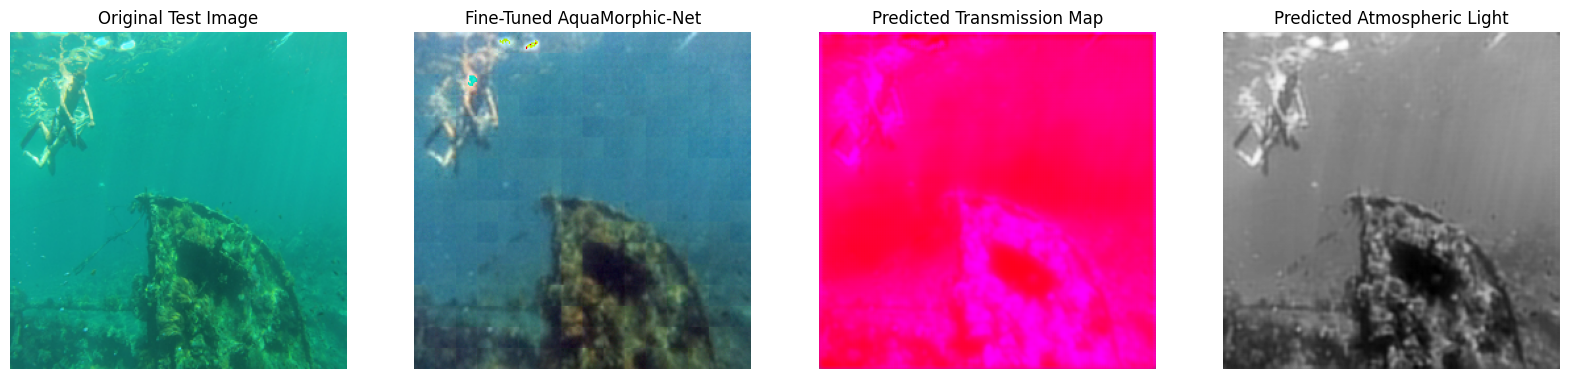

In [ ]:
#  Inference and Visualization
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

# Import the model architecture
from AquaMorphicNet import AquaMorphicNet

# --- Configuration (pointing to your BEST model) ---
MODEL_PATH = "/content/drive/My Drive/AquaMorphic_Checkpoints/model_finetuned.pth"
TEST_IMAGE_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Find a test image automatically
try:
    INPUT_IMAGE_PATH = "/content/drive/MyDrive/UIEB_SPLIT/test/raw/143_img_.png"#glob.glob(os.path.join(TEST_IMAGE_DIR, '*'))[5] # Using the 6th image (index 5) for variety
    print(f"Using test image: {os.path.basename(INPUT_IMAGE_PATH)}")
except IndexError:
    print(f"Error: No images found in {TEST_IMAGE_DIR}. Please check the path.")
    INPUT_IMAGE_PATH = None

if INPUT_IMAGE_PATH:
    # --- Load Model ---
    model = AquaMorphicNet(image_size=IMAGE_SIZE, patch_size=16).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model '{os.path.basename(MODEL_PATH)}' loaded successfully from Google Drive.")

    # --- Image Pre-processing ---
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    # --- Run Inference ---
    input_image = Image.open(INPUT_IMAGE_PATH).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor, t_map, a_map = model(input_tensor)

    # --- Display Results ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Test Image")
    axes[0].axis('off')

    # Restored Image
    restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())
    axes[1].imshow(restored_pil)
    axes[1].set_title("Fine-Tuned AquaMorphic-Net")
    axes[1].axis('off')

    # Transmission Map
    t_map_pil = transforms.ToPILImage()(t_map.squeeze(0).cpu())
    axes[2].imshow(t_map_pil)
    axes[2].set_title("Predicted Transmission Map")
    axes[2].axis('off')

    # Atmospheric Light Map
    a_map_pil = transforms.ToPILImage()(a_map.squeeze(0).cpu())
    axes[3].imshow(a_map_pil, cmap='gray')
    axes[3].set_title("Predicted Atmospheric Light")
    axes[3].axis('off')

    plt.show()

In [ ]:

%%writefile AquaMorphicUNet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# --- Building Blocks (Attention and Transformer are the same) ---
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head)),
                PreNorm(dim, FeedForward(dim, mlp_dim))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# --- NEW: U-Net Components ---

class ConvBlock(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then ConvBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_ch, out_ch)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then ConvBlock"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1 is from previous upsample, x2 is skip connection from encoder
        x1 = self.up(x1)
        # Pad x1 if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# --- Physics Branch (same as before) ---
class PhysicsBranch(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, out_channels, 3, 1, 1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        t_map = torch.sigmoid(x[:, :3, :, :])
        a_map = torch.sigmoid(x[:, 3:, :, :])
        return t_map, a_map

# --- The Main Upgraded Model: AquaMorphic-UNet ---
class AquaMorphicUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # --- Physics Branch ---
        self.physics_branch = PhysicsBranch()

        # --- U-Net Encoder ---
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        # --- Transformer Bottleneck ---
        self.bot1 = Transformer(dim=512, depth=2, heads=8, dim_head=64, mlp_dim=1024)
        self.bot2 = Transformer(dim=512, depth=2, heads=8, dim_head=64, mlp_dim=1024)

        # --- U-Net Decoder ---
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # --- Physics Prediction ---
        t_map, a_map = self.physics_branch(x)

        # --- Encoder Path ---
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # --- Transformer Bottleneck ---
        b, c, h, w = x5.shape
        x5_flat = rearrange(x5, 'b c h w -> b (h w) c')

        t_map_bot = F.interpolate(t_map, size=(h,w), mode='bilinear')
        a_map_bot = F.interpolate(a_map, size=(h,w), mode='bilinear')
        physics_feat = torch.cat([t_map_bot, a_map_bot], dim=1) # Concatenate along channel dim
        physics_feat_flat = rearrange(physics_feat, 'b c h w -> b (h w) c')

        physics_proj = nn.Conv2d(4, 512, kernel_size=1).to(x.device)(torch.cat([t_map_bot, a_map_bot], dim=1))
        physics_proj_flat = rearrange(physics_proj, 'b c h w -> b (h w) c')

        bot_out1 = self.bot1(x5_flat + physics_proj_flat) # Inject physics info
        bot_out2 = self.bot2(bot_out1)

        bot_out_reshaped = rearrange(bot_out2, 'b (h w) c -> b c h w', h=h, w=w)

        # --- Decoder Path with Skip Connections ---
        up_out = self.up1(bot_out_reshaped, x4) # Skip connection from x4
        up_out = self.up2(up_out, x3)           # Skip connection from x3
        up_out = self.up3(up_out, x2)           # Skip connection from x2
        up_out = self.up4(up_out, x1)           # Skip connection from x1

        restored_img = torch.tanh(self.outc(up_out))

        return restored_img, t_map, a_map

Writing AquaMorphicUNet.py


In [ ]:
# Create the train_unet.py file
%%writefile train_unet.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from tqdm import tqdm
import glob

# Import our NEW model
from AquaMorphicUNet import AquaMorphicUNet

# --- 1. Dataset Class  ---
class UIEBDataset(Dataset):
    def __init__(self, root_dir, image_size=128):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])

        # For tanh output, we normalize to [-1, 1]
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.gt_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        underwater_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        gt_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')
        return self.transform(underwater_img), self.gt_transform(gt_img)

# --- 2. Training Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 2
NUM_EPOCHS = 100
IMAGE_SIZE = 128
DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/train"
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_UNet_Checkpoints"
LAMBDA_PHYSICS = 0.3

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- 3. Training Logic ---
def train_fn(model, loader, optimizer, l1_loss, physics_loss_weight):
    loop = tqdm(loader, leave=True)
    for underwater, ground_truth in loop:
        underwater = underwater.to(DEVICE)
        ground_truth = ground_truth.to(DEVICE)

        restored, t_map, a_map = model(underwater)

        loss_recon = l1_loss(restored, ground_truth)

        a_map_3ch = a_map.repeat(1, 3, 1, 1)

        # We need to scale T and A from [0,1] to [-1,1] to match the normalized image space
        t_map_norm = t_map * 2 - 1
        a_map_norm = a_map_3ch * 2 - 1

        # Physics loss should operate on normalized images
        physics_reconstructed = restored * t_map_norm + a_map_norm * (1 - t_map_norm)
        # I = J*T + A*(1-T)
        underwater_01 = (underwater * 0.5) + 0.5
        restored_01 = (restored * 0.5) + 0.5

        physics_reconstructed_01 = restored_01 * t_map + a_map_3ch * (1 - t_map)
        loss_physics = l1_loss(underwater_01, physics_reconstructed_01)

        loss = loss_recon + physics_loss_weight * loss_physics

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(L1=loss_recon.item(), Physics=loss_physics.item())

# --- 4. Main Execution ---
if __name__ == "__main__":
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
    l1_loss = nn.L1Loss()

    train_dataset = UIEBDataset(root_dir=DATA_DIR, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    print(f"Starting training for new AquaMorphic-UNet...")
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(model, train_loader, optimizer, l1_loss, LAMBDA_PHYSICS)
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"unet_model_epoch_{epoch+1}.pth"))
            print(f"Checkpoint saved.")

    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "unet_model_final.pth"))
    print("\nTraining complete.")

Writing train_unet.py


In [ ]:
!python train_unet.py

Starting training for new AquaMorphic-UNet...
--- Epoch 1/100 ---
100% 401/401 [13:13<00:00,  1.98s/it, L1=0.392, Physics=0.103]
--- Epoch 2/100 ---
100% 401/401 [12:02<00:00,  1.80s/it, L1=0.216, Physics=0.0781]
--- Epoch 3/100 ---
100% 401/401 [12:04<00:00,  1.81s/it, L1=0.161, Physics=0.0573]
--- Epoch 4/100 ---
100% 401/401 [12:10<00:00,  1.82s/it, L1=0.344, Physics=0.0611]
--- Epoch 5/100 ---
100% 401/401 [12:17<00:00,  1.84s/it, L1=0.382, Physics=0.104]
--- Epoch 6/100 ---
100% 401/401 [12:08<00:00,  1.82s/it, L1=0.356, Physics=0.0584]
--- Epoch 7/100 ---
100% 401/401 [12:06<00:00,  1.81s/it, L1=0.197, Physics=0.0542]
--- Epoch 8/100 ---
100% 401/401 [11:47<00:00,  1.77s/it, L1=0.12, Physics=0.0506]
--- Epoch 9/100 ---
100% 401/401 [12:07<00:00,  1.81s/it, L1=0.193, Physics=0.13]
--- Epoch 10/100 ---
100% 401/401 [11:54<00:00,  1.78s/it, L1=0.4, Physics=0.0503]
Checkpoint saved.
--- Epoch 11/100 ---
100% 401/401 [11:44<00:00,  1.76s/it, L1=0.361, Physics=0.0401]
--- Epoch 12/100 

Using test image: 13_img_.png
Model 'unet_model_final.pth' loaded successfully from Google Drive.


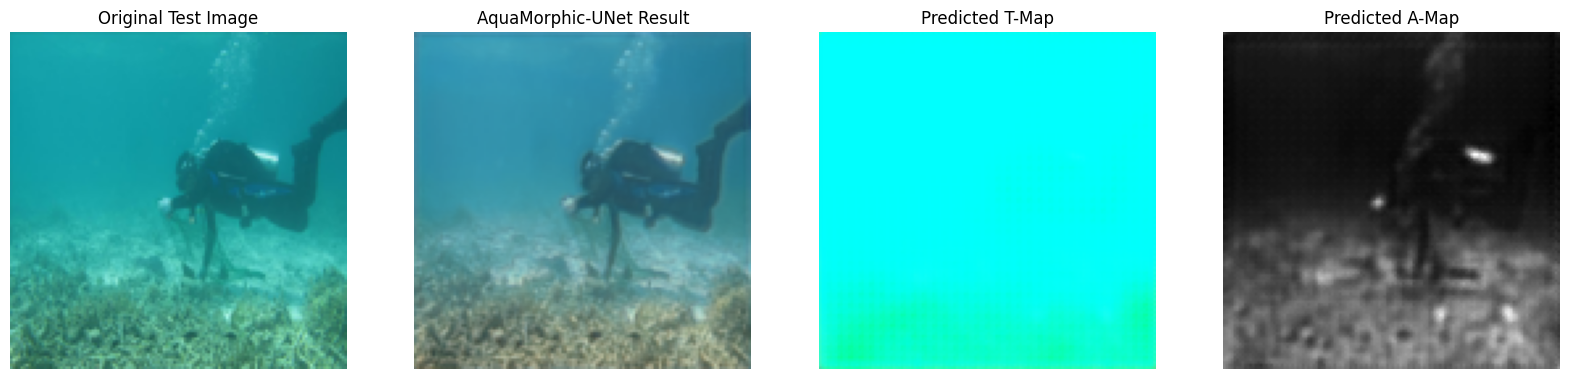

In [ ]:
# Cell 6: Inference and Visualization for AquaMorphic-UNet (COLAB PATHS)

import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

try:
    from AquaMorphicUNet import AquaMorphicUNet
except ImportError:
    print("Could not import AquaMorphicUNet. Please re-run the cell that defines the model.")

# --- Configuration (COLAB PATHS) ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_UNet_Checkpoints/unet_model_final.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"
IMAGE_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Function to de-normalize image from [-1, 1] to [0, 1] for display
def denorm(tensor):
    return tensor * 0.5 + 0.5

try:
    test_files = glob.glob(os.path.join(TEST_DATA_DIR, '*'))
    INPUT_IMAGE_PATH = next((f for f in test_files if '13_img_.png' in f), test_files[0])
    print(f"Using test image: {os.path.basename(INPUT_IMAGE_PATH)}")
except IndexError:
    print(f"Error: No images found in {TEST_DATA_DIR}. Please check the path.")
    INPUT_IMAGE_PATH = None

if INPUT_IMAGE_PATH:
    # --- Load Model ---
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model '{os.path.basename(MODEL_PATH)}' loaded successfully from Google Drive.")

    # --- Image Pre-processing (must match training) ---
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # --- Run Inference ---
    input_image = Image.open(INPUT_IMAGE_PATH).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor, t_map, a_map = model(input_tensor)

    # --- Display Results ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Test Image")
    axes[0].axis('off')

    restored_pil = transforms.ToPILImage()(denorm(restored_tensor.squeeze(0).cpu()))
    axes[1].imshow(restored_pil)
    axes[1].set_title("AquaMorphic-UNet Result")
    axes[1].axis('off')

    t_map_pil = transforms.ToPILImage()(t_map.squeeze(0).cpu())
    axes[2].imshow(t_map_pil)
    axes[2].set_title("Predicted T-Map")
    axes[2].axis('off')

    a_map_pil = transforms.ToPILImage()(a_map.squeeze(0).cpu())
    axes[3].imshow(a_map_pil, cmap='gray')
    axes[3].set_title("Predicted A-Map")
    axes[3].axis('off')

    plt.show()

In [ ]:
# Cell 7: Quantitative Evaluation for AquaMorphic-UNet (COLAB PATHS)

# --- 1. Install necessary library ---
!pip install -q scikit-image

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --- Make sure the model definition is available ---
try:
    from AquaMorphicUNet import AquaMorphicUNet
except ImportError:
    print("Could not import AquaMorphicUNet. Please re-run the cell that defines the model.")

# --- 2. Configuration (COLAB PATHS) ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_UNet_Checkpoints/unet_model_epoch_60.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 128 # Must match training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Function to de-normalize image from [-1, 1] to [0, 1] for metrics
def denorm_for_metrics(tensor):
    return (tensor.squeeze(0).cpu() * 0.5 + 0.5)

# --- 3. Load Model ---
model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model '{os.path.basename(MODEL_PATH)}' loaded successfully from Google Drive.")

    # --- 4. Prepare for Evaluation ---
    transform_in = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_gt = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    test_raw_path = os.path.join(TEST_DATA_DIR, 'raw')
    test_ref_path = os.path.join(TEST_DATA_DIR, 'reference')
    test_files = sorted(glob.glob(os.path.join(test_raw_path, '*')))

    psnr_scores = []
    ssim_scores = []

    print(f"\nStarting evaluation on {len(test_files)} test images...")

    # --- 5. Evaluation Loop ---
    with torch.no_grad():
        for raw_file_path in tqdm(test_files):
            filename = os.path.basename(raw_file_path)
            ref_file_path = os.path.join(test_ref_path, filename)

            raw_img = Image.open(raw_file_path).convert('RGB')
            ref_img = Image.open(ref_file_path).convert('RGB')

            input_tensor = transform_in(raw_img).unsqueeze(0).to(DEVICE)
            gt_tensor_01 = transform_gt(ref_img)

            restored_tensor, _, _ = model(input_tensor)
            restored_tensor_01 = denorm_for_metrics(restored_tensor)

            restored_np = np.transpose(restored_tensor_01.numpy(), (1, 2, 0))
            gt_np = np.transpose(gt_tensor_01.numpy(), (1, 2, 0))

            restored_np = np.clip(restored_np, 0, 1)
            gt_np = np.clip(gt_np, 0, 1)

            current_psnr = psnr(gt_np, restored_np, data_range=1.0)
            current_ssim = ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1)

            psnr_scores.append(current_psnr)
            ssim_scores.append(current_ssim)

    # --- 6. Report Final Scores ---
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    print("\n---" + "="*30 + "---")
    print("    AquaMorphic-UNet Evaluation Complete")
    print("---" + "="*30 + "---")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print("---" + "="*30 + "---")

Model 'unet_model_epoch_60.pth' loaded successfully from Google Drive.

Starting evaluation on 89 test images...


100%|██████████| 89/89 [00:45<00:00,  1.95it/s]


---==============================---
    AquaMorphic-UNet Evaluation Complete
---==============================---
Average PSNR: 17.55 dB
Average SSIM: 0.7269
---==============================---


In [ ]:
# Create the vgg_loss.py file
%%writefile vgg_loss.py

import torch
import torch.nn as nn
import torchvision.models as models

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        # Load the VGG16 model pre-trained on ImageNet
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.feature_extractor = nn.Sequential(
            *vgg[:23]
        )

        # We use L1 loss to compare the feature maps
        self.loss_fn = nn.L1Loss()

        # Normalization parameters for ImageNet, which VGG was trained on
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input_img, target_img):

        # Normalize the images to match VGG's expected input format
        input_norm = (input_img - self.mean) / self.std
        target_norm = (target_img - self.mean) / self.std

        # Extract features
        input_features = self.feature_extractor(input_norm)
        target_features = self.feature_extractor(target_norm)

        # Calculate the loss
        perceptual_loss = self.loss_fn(input_features, target_features)

        return perceptual_loss

Writing vgg_loss.py


In [ ]:

%%writefile train_perceptual.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from tqdm import tqdm
import glob

from AquaMorphicUNet import AquaMorphicUNet
from vgg_loss import VGGPerceptualLoss

class UIEBDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        underwater_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        gt_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')

        return self.transform(underwater_img), self.transform(gt_img)

# --- CONFIGURATION FOR PERCEPTUAL TRAINING ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 2
NUM_EPOCHS = 50
IMAGE_SIZE = 256
DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/train"
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Perceptual_Checkpoints"

# --- LOSS WEIGHTS (Hyperparameters to tune) ---
LAMBDA_L1 = 1.0
LAMBDA_PERCEPTUAL = 0.1
LAMBDA_PHYSICS = 0.4

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def train_fn(model, loader, optimizer, l1_loss, perceptual_loss_fn, loss_weights):
    loop = tqdm(loader, leave=True)
    for underwater, ground_truth in loop:
        underwater, ground_truth = underwater.to(DEVICE), ground_truth.to(DEVICE)

        restored, t_map, a_map = model(underwater)

        # --- CALCULATE ALL THREE LOSSES ---
        # 1. L1 Loss (for pixel-level accuracy)
        loss_l1 = l1_loss(restored, ground_truth)

        # 2. Perceptual Loss (for high-level feature accuracy)
        loss_p = perceptual_loss_fn(restored, ground_truth)

        # 3. Physics Loss (for physical consistency)
        a_map_3ch = a_map.repeat(1, 3, 1, 1)
        physics_reconstructed = restored * t_map + a_map_3ch * (1 - t_map)
        loss_physics = l1_loss(underwater, physics_reconstructed)

        # --- COMBINE LOSSES ---
        loss = (loss_weights['l1'] * loss_l1 +
                loss_weights['perceptual'] * loss_p +
                loss_weights['physics'] * loss_physics)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(L1=loss_l1.item(), Perceptual=loss_p.item(), Physics=loss_physics.item())

if __name__ == "__main__":
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    # Initialize all loss functions
    l1_loss = nn.L1Loss()
    perceptual_loss = VGGPerceptualLoss().to(DEVICE)
    loss_weights = {'l1': LAMBDA_L1, 'perceptual': LAMBDA_PERCEPTUAL, 'physics': LAMBDA_PHYSICS}

    train_dataset = UIEBDataset(root_dir=DATA_DIR, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    print("Starting PERCEPTUAL training for AquaMorphic-UNet...")
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(model, train_loader, optimizer, l1_loss, perceptual_loss, loss_weights)
        scheduler.step()

        # Save the final model continuously
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "perceptual_model_final.pth"))
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"perceptual_model_epoch_{epoch+1}.pth"))
            print("Checkpoint saved.")

    print("\nPerceptual training complete.")

Overwriting train_perceptual.py


In [ ]:
!python train_perceptual.py

Starting PERCEPTUAL training for AquaMorphic-UNet...
--- Epoch 1/50 ---
100% 401/401 [01:14<00:00,  5.39it/s, L1=0.0771, Perceptual=0.287, Physics=0.158]
--- Epoch 2/50 ---
100% 401/401 [01:13<00:00,  5.48it/s, L1=0.127, Perceptual=0.266, Physics=0.143]
--- Epoch 3/50 ---
100% 401/401 [01:11<00:00,  5.57it/s, L1=0.11, Perceptual=0.359, Physics=0.0867]
--- Epoch 4/50 ---
100% 401/401 [01:11<00:00,  5.60it/s, L1=0.195, Perceptual=0.582, Physics=0.118]
--- Epoch 5/50 ---
100% 401/401 [01:12<00:00,  5.56it/s, L1=0.0798, Perceptual=0.217, Physics=0.0416]
--- Epoch 6/50 ---
100% 401/401 [01:12<00:00,  5.52it/s, L1=0.234, Perceptual=0.403, Physics=0.107]
--- Epoch 7/50 ---
100% 401/401 [01:12<00:00,  5.53it/s, L1=0.177, Perceptual=0.332, Physics=0.17]
--- Epoch 8/50 ---
100% 401/401 [01:11<00:00,  5.60it/s, L1=0.204, Perceptual=0.435, Physics=0.116]
--- Epoch 9/50 ---
100% 401/401 [01:11<00:00,  5.62it/s, L1=0.349, Perceptual=0.539, Physics=0.0638]
--- Epoch 10/50 ---
100% 401/401 [01:13<00:0

In [ ]:
# Quantitative Evaluation for the Perceptual Model

!pip install -q scikit-image
import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

try:
    from AquaMorphicUNet import AquaMorphicUNet
except ImportError:
    print("Could not import AquaMorphicUNet.")

# --- CONFIGURATION ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_Perceptual_Checkpoints/model_final_polished.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"Model '{os.path.basename(MODEL_PATH)}' loaded.")

transform_in_out = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
test_raw_path = os.path.join(TEST_DATA_DIR, 'raw')
test_ref_path = os.path.join(TEST_DATA_DIR, 'reference')
test_files = sorted(glob.glob(os.path.join(test_raw_path, '*')))
psnr_scores, ssim_scores = [], []

print(f"\nStarting evaluation on {len(test_files)} test images...")
with torch.no_grad():
    for raw_file_path in tqdm(test_files):
        filename = os.path.basename(raw_file_path)
        ref_file_path = os.path.join(test_ref_path, filename)
        raw_img = Image.open(raw_file_path).convert('RGB')
        ref_img = Image.open(ref_file_path).convert('RGB')
        input_tensor = transform_in_out(raw_img).unsqueeze(0).to(DEVICE)
        gt_tensor = transform_in_out(ref_img)
        restored_tensor, _, _ = model(input_tensor)
        restored_np = np.transpose(restored_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))
        gt_np = np.transpose(gt_tensor.numpy(), (1, 2, 0))
        restored_np, gt_np = np.clip(restored_np, 0, 1), np.clip(gt_np, 0, 1)
        psnr_scores.append(psnr(gt_np, restored_np, data_range=1.0))
        ssim_scores.append(ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1))

avg_psnr, avg_ssim = np.mean(psnr_scores), np.mean(ssim_scores)
print("\n--- Perceptual Model Evaluation Complete ---")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")

Model 'model_final_polished.pth' loaded.

Starting evaluation on 89 test images...


100%|██████████| 89/89 [00:09<00:00,  9.52it/s]


--- Perceptual Model Evaluation Complete ---
Average PSNR: 18.18 dB
Average SSIM: 0.7857


Using test image: 13_img_.png
Model 'model_final_polished.pth' loaded successfully.


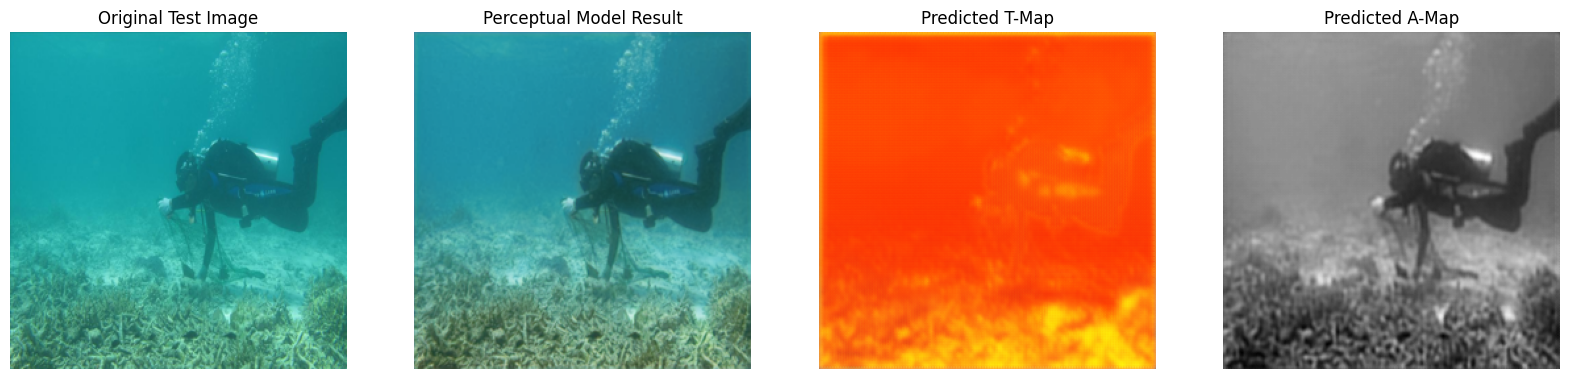

In [ ]:
# Inference for the Perceptual Model

import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

try:
    from AquaMorphicUNet import AquaMorphicUNet
except ImportError:
    print("Could not import AquaMorphicUNet. Please re-run the cell that defines the model.")

# --- CONFIGURATION ---
MODEL_PATH = "/content/drive/MyDrive/AquaMorphic_Perceptual_Checkpoints/model_final_polished.pth"
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"
IMAGE_SIZE = 256 # Match the perceptual training image size
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def denorm(tensor): # We don't need denorm since we trained on [0,1]
    return tensor

# Find a test image
try:
    test_files = glob.glob(os.path.join(TEST_DATA_DIR, '*'))
    INPUT_IMAGE_PATH = "/content/drive/MyDrive/UIEB_SPLIT/test/raw/13_img_.png"#next((f for f in test_files if '139_img_.png' in f), test_files[0])
    print(f"Using test image: {os.path.basename(INPUT_IMAGE_PATH)}")
except IndexError:
    print(f"Error: No images found.")
    INPUT_IMAGE_PATH = None

if INPUT_IMAGE_PATH:
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Model '{os.path.basename(MODEL_PATH)}' loaded successfully.")

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(), # To [0, 1]
    ])

    input_image = Image.open(INPUT_IMAGE_PATH).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor, t_map, a_map = model(input_tensor)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Test Image")
    axes[0].axis('off')

    restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())
    axes[1].imshow(restored_pil)
    axes[1].set_title("Perceptual Model Result")
    axes[1].axis('off')

    axes[2].imshow(transforms.ToPILImage()(t_map.squeeze(0).cpu()))
    axes[2].set_title("Predicted T-Map")
    axes[2].axis('off')

    axes[3].imshow(transforms.ToPILImage()(a_map.squeeze(0).cpu()), cmap='gray')
    axes[3].set_title("Predicted A-Map")
    axes[3].axis('off')

    plt.show()

In [ ]:
# Create the final_finetune.py script
%%writefile final_finetune.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from tqdm import tqdm
import glob

# Import our model and the loss function
from AquaMorphicUNet import AquaMorphicUNet
from vgg_loss import VGGPerceptualLoss

class UIEBDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        underwater_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        gt_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')
        return self.transform(underwater_img), self.transform(gt_img)

# --- CONFIGURATION FOR FINAL FINE-TUNING ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5  # CRITICAL: Lower learning rate for fine-tuning
BATCH_SIZE = 2
NUM_EPOCHS = 20       # Short fine-tuning run
IMAGE_SIZE = 256
DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/train"
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Perceptual_Checkpoints"

# Loss weights can remain the same or be tweaked slightly
LAMBDA_L1 = 1.0
LAMBDA_PERCEPTUAL = 0.1
LAMBDA_PHYSICS = 0.4

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def train_fn(model, loader, optimizer, l1_loss, perceptual_loss_fn, loss_weights):
    loop = tqdm(loader, leave=True)
    for underwater, ground_truth in loop:
        underwater, ground_truth = underwater.to(DEVICE), ground_truth.to(DEVICE)
        restored, t_map, a_map = model(underwater)
        loss_l1 = l1_loss(restored, ground_truth)
        loss_p = perceptual_loss_fn(restored, ground_truth)
        a_map_3ch = a_map.repeat(1, 3, 1, 1)
        physics_reconstructed = restored * t_map + a_map_3ch * (1 - t_map)
        loss_physics = l1_loss(underwater, physics_reconstructed)
        loss = (loss_weights['l1'] * loss_l1 +
                loss_weights['perceptual'] * loss_p +
                loss_weights['physics'] * loss_physics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(L1=loss_l1.item(), Perceptual=loss_p.item(), Physics=loss_physics.item())

if __name__ == "__main__":
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    # Use a simple Adam optimizer without a scheduler for this short run
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

    l1_loss = nn.L1Loss()
    perceptual_loss = VGGPerceptualLoss().to(DEVICE)
    loss_weights = {'l1': LAMBDA_L1, 'perceptual': LAMBDA_PERCEPTUAL, 'physics': LAMBDA_PHYSICS}

    # --- LOAD THE BEST CHECKPOINT ---
    start_checkpoint_path = os.path.join(CHECKPOINT_DIR, "perceptual_model_epoch_40.pth")
    save_checkpoint_path = os.path.join(CHECKPOINT_DIR, "model_final_polished.pth")

    if os.path.exists(start_checkpoint_path):
        print(f"Loading best checkpoint '{os.path.basename(start_checkpoint_path)}' for final fine-tuning...")
        model.load_state_dict(torch.load(start_checkpoint_path))
    else:
        print(f"ERROR: Cannot find '{os.path.basename(start_checkpoint_path)}'. Aborting.")
        exit()

    train_dataset = UIEBDataset(root_dir=DATA_DIR, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    print(f"\nStarting final polishing run for {NUM_EPOCHS} epochs with LR={LEARNING_RATE}.")
    for epoch in range(NUM_EPOCHS):
        print(f"--- Fine-Tuning Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(model, train_loader, optimizer, l1_loss, perceptual_loss, loss_weights)

        # Save the polished model continuously
        torch.save(model.state_dict(), save_checkpoint_path)

    print("\nPolishing complete.")
    print(f"Final polished model saved as '{os.path.basename(save_checkpoint_path)}'")

Overwriting final_finetune.py


In [ ]:
!python final_finetune.py

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:06<00:00, 85.4MB/s]
Loading best checkpoint 'perceptual_model_epoch_40.pth' for final fine-tuning...

Starting final polishing run for 20 epochs with LR=1e-05.
--- Fine-Tuning Epoch 1/20 ---
100% 401/401 [05:52<00:00,  1.14it/s, L1=0.104, Perceptual=0.21, Physics=0.113]
--- Fine-Tuning Epoch 2/20 ---
100% 401/401 [01:12<00:00,  5.54it/s, L1=0.0708, Perceptual=0.12, Physics=0.0556]
--- Fine-Tuning Epoch 3/20 ---
100% 401/401 [01:14<00:00,  5.39it/s, L1=0.0517, Perceptual=0.171, Physics=0.0635]
--- Fine-Tuning Epoch 4/20 ---
100% 401/401 [01:13<00:00,  5.46it/s, L1=0.199, Perceptual=0.49, Physics=0.0746]
--- Fine-Tuning Epoch 5/20 ---
100% 401/401 [01:12<00:00,  5.51it/s, L1=0.0886, Perceptual=0.231, Physics=0.0818]
--- Fine-Tuning Epoch 6/20 ---
100% 401/401 [01:13<00:00,  5.44it/s, L1=0.242, Perceptual=0.363, Physics=0.108]
--- Fine-Tuning Ep

Augmented


In [ ]:
# This class will go inside your new training script.

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import glob
import random

class UIEBDataset_Augmented(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])
        self.image_size = image_size

        # --- Define Augmentation Pipelines ---

        # 1. Color Augmentations (applied to input/raw image ONLY)
        self.color_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)

        # 2. Final conversion to tensor (applied after all other transforms)
        self.to_tensor = transforms.ToTensor() # Converts PIL image in range [0, 255] to Tensor in range [0, 1]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        raw_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        ref_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')

        # --- Apply Augmentations ON-THE-FLY ---

        # 1. Apply Color Jitter to the underwater (raw) image ONLY
        raw_img = self.color_transform(raw_img)

        # 2. Apply IDENTICAL Geometric Augmentations to the pair

        # Random Horizontal Flip
        if random.random() > 0.5:
            raw_img = transforms.functional.hflip(raw_img)
            ref_img = transforms.functional.hflip(ref_img)

        # Random Rotation
        if random.random() > 0.5:
            angle = random.uniform(-15, 15) # Get a random angle
            raw_img = transforms.functional.rotate(raw_img, angle)
            ref_img = transforms.functional.rotate(ref_img, angle)

        # 3. Final Resizing and Conversion to Tensor
        resize = transforms.Resize((self.image_size, self.image_size))
        raw_img = resize(raw_img)
        ref_img = resize(ref_img)

        raw_tensor = self.to_tensor(raw_img)
        ref_tensor = self.to_tensor(ref_img)

        return raw_tensor, ref_tensor

In [ ]:
# Create the train_augmented.py file
%%writefile train_augmented.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
from tqdm import tqdm
import glob
import random

# Import our model and the loss function
from AquaMorphicUNet import AquaMorphicUNet
from vgg_loss import VGGPerceptualLoss

# --- 1. Upgraded Dataset Class with Augmentations ---
class UIEBDataset_Augmented(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.underwater_path = os.path.join(root_dir, 'raw')
        self.gt_path = os.path.join(root_dir, 'reference')
        self.file_list = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.underwater_path, '*'))])
        self.image_size = image_size
        self.color_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        raw_img = Image.open(os.path.join(self.underwater_path, filename)).convert('RGB')
        ref_img = Image.open(os.path.join(self.gt_path, filename)).convert('RGB')
        raw_img = self.color_transform(raw_img)
        if random.random() > 0.5:
            raw_img = transforms.functional.hflip(raw_img)
            ref_img = transforms.functional.hflip(ref_img)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            raw_img = transforms.functional.rotate(raw_img, angle)
            ref_img = transforms.functional.rotate(ref_img, angle)
        resize = transforms.Resize((self.image_size, self.image_size))
        raw_img, ref_img = resize(raw_img), resize(ref_img)
        return self.to_tensor(raw_img), self.to_tensor(ref_img)

# --- 2. CONFIGURATION FOR AUGMENTED TRAINING ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4 # Start with a slightly higher LR for training from scratch
BATCH_SIZE = 2
NUM_EPOCHS = 80      # Let's train longer, as augmentation fights overfitting
IMAGE_SIZE = 256
DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/train"
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Augmented_Checkpoints"
LAMBDA_L1, LAMBDA_PERCEPTUAL, LAMBDA_PHYSICS = 1.0, 0.1, 0.4
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- 3. Training Function (no changes) ---
def train_fn(model, loader, optimizer, l1_loss, perceptual_loss_fn, loss_weights):
    loop = tqdm(loader, leave=True)
    for underwater, ground_truth in loop:
        underwater, ground_truth = underwater.to(DEVICE), ground_truth.to(DEVICE)
        restored, t_map, a_map = model(underwater)
        loss_l1 = l1_loss(restored, ground_truth)
        loss_p = perceptual_loss_fn(restored, ground_truth)
        a_map_3ch = a_map.repeat(1, 3, 1, 1)
        physics_reconstructed = restored * t_map + a_map_3ch * (1 - t_map)
        loss_physics = l1_loss(underwater, physics_reconstructed)
        loss = (loss_weights['l1'] * loss_l1 +
                loss_weights['perceptual'] * loss_p +
                loss_weights['physics'] * loss_physics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(L1=loss_l1.item(), Perceptual=loss_p.item(), Physics=loss_physics.item())

# --- 4. Main Execution ---
if __name__ == "__main__":
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    l1_loss = nn.L1Loss()
    perceptual_loss = VGGPerceptualLoss().to(DEVICE)
    loss_weights = {'l1': LAMBDA_L1, 'perceptual': LAMBDA_PERCEPTUAL, 'physics': LAMBDA_PHYSICS}

    # Use the new augmented dataset class
    train_dataset = UIEBDataset_Augmented(root_dir=DATA_DIR, image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    print("Starting training from scratch with ON-THE-FLY AUGMENTATION...")
    for epoch in range(NUM_EPOCHS):
        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_fn(model, train_loader, optimizer, l1_loss, perceptual_loss, loss_weights)
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"augmented_model_epoch_{epoch+1}.pth"))
            print("Checkpoint saved.")

    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "augmented_model_final.pth"))
    print("\nAugmented training complete.")

Overwriting train_augmented.py


In [ ]:
!python train_augmented.py

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 196MB/s]
Starting training from scratch with ON-THE-FLY AUGMENTATION...
--- Epoch 1/80 ---
100% 401/401 [06:50<00:00,  1.02s/it, L1=0.096, Perceptual=0.27, Physics=0.136]
--- Epoch 2/80 ---
100% 401/401 [01:46<00:00,  3.78it/s, L1=0.0922, Perceptual=0.274, Physics=0.051]
--- Epoch 3/80 ---
100% 401/401 [01:47<00:00,  3.72it/s, L1=0.0846, Perceptual=0.238, Physics=0.0769]
--- Epoch 4/80 ---
100% 401/401 [01:48<00:00,  3.71it/s, L1=0.114, Perceptual=0.342, Physics=0.043]
--- Epoch 5/80 ---
100% 401/401 [01:46<00:00,  3.76it/s, L1=0.109, Perceptual=0.283, Physics=0.0497]
--- Epoch 6/80 ---
100% 401/401 [01:47<00:00,  3.72it/s, L1=0.0535, Perceptual=0.215, Physics=0.1]
--- Epoch 7/80 ---
100% 401/401 [01:48<00:00,  3.68it/s, L1=0.0804, Perceptual=0.195, Physics=0.0957]
--- Epoch 8/80 ---
100% 401/401 [01:48<00:00,  3.71it/s, L1=0.167, P

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# --- Building Blocks (Attention and Transformer are the same) ---
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head)),
                PreNorm(dim, FeedForward(dim, mlp_dim))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# --- NEW: U-Net Components ---

class ConvBlock(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then ConvBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_ch, out_ch)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then ConvBlock"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1 is from previous upsample, x2 is skip connection from encoder
        x1 = self.up(x1)
        # Pad x1 if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# --- Physics Branch (same as before) ---
class PhysicsBranch(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, out_channels, 3, 1, 1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        t_map = torch.sigmoid(x[:, :3, :, :])
        a_map = torch.sigmoid(x[:, 3:, :, :])
        return t_map, a_map

# --- The Main Upgraded Model: AquaMorphic-UNet ---
class AquaMorphicUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # --- Physics Branch ---
        self.physics_branch = PhysicsBranch()

        # --- U-Net Encoder ---
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        # --- Transformer Bottleneck ---
        self.bot1 = Transformer(dim=512, depth=2, heads=8, dim_head=64, mlp_dim=1024)
        self.bot2 = Transformer(dim=512, depth=2, heads=8, dim_head=64, mlp_dim=1024)

        # --- U-Net Decoder ---
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # --- Physics Prediction ---
        t_map, a_map = self.physics_branch(x)

        # --- Encoder Path ---
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # --- Transformer Bottleneck ---
        b, c, h, w = x5.shape
        x5_flat = rearrange(x5, 'b c h w -> b (h w) c')

        t_map_bot = F.interpolate(t_map, size=(h,w), mode='bilinear')
        a_map_bot = F.interpolate(a_map, size=(h,w), mode='bilinear')
        physics_feat = torch.cat([t_map_bot, a_map_bot], dim=1) # Concatenate along channel dim
        physics_feat_flat = rearrange(physics_feat, 'b c h w -> b (h w) c')

        physics_proj = nn.Conv2d(4, 512, kernel_size=1).to(x.device)(torch.cat([t_map_bot, a_map_bot], dim=1))
        physics_proj_flat = rearrange(physics_proj, 'b c h w -> b (h w) c')

        bot_out1 = self.bot1(x5_flat + physics_proj_flat) # Inject physics info
        bot_out2 = self.bot2(bot_out1)

        bot_out_reshaped = rearrange(bot_out2, 'b (h w) c -> b c h w', h=h, w=w)

        # --- Decoder Path with Skip Connections ---
        up_out = self.up1(bot_out_reshaped, x4) # Skip connection from x4
        up_out = self.up2(up_out, x3)           # Skip connection from x3
        up_out = self.up3(up_out, x2)           # Skip connection from x2
        up_out = self.up4(up_out, x1)           # Skip connection from x1

        restored_img = torch.tanh(self.outc(up_out))

        return restored_img, t_map, a_map

Successfully loaded: augmented_model_epoch_70.pth

--- Running Visual Inference ---


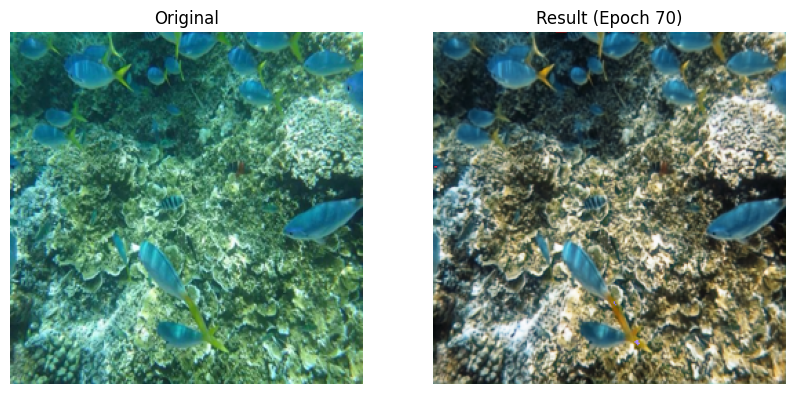


--- Running Quantitative Evaluation ---


Evaluating Epoch 70: 100%|██████████| 89/89 [02:39<00:00,  1.79s/it]


--- Evaluation Complete ---
Results:
Average PSNR: 17.59 dB
Average SSIM: 0.7796


In [ ]:
# Cell 3: Evaluation Script for Intermediate Checkpoints

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# --- ⚠️ EDIT THIS VARIABLE TO CHOOSE THE CHECKPOINT ---
EPOCH_TO_TEST = 70
# ----------------------------------------------------

# --- Configuration ---
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Augmented_Checkpoints"
MODEL_FILENAME = f"augmented_model_epoch_{EPOCH_TO_TEST}.pth"
MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256 # Match the training image size
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# --- Load Model and Run Evaluation ---
model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)

if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
    print("Please check that the checkpoint for the specified epoch has been saved.")
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Successfully loaded: {MODEL_FILENAME}")

    # --- 1. Visual Inference on a sample image ---
    print("\n--- Running Visual Inference ---")
    test_raw_dir = os.path.join(TEST_DATA_DIR, 'raw')
    sample_image_path = glob.glob(os.path.join(test_raw_dir, '*'))[5] # Pick the 6th image

    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    input_image = Image.open(sample_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor, _, _ = model(input_tensor)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original")
    axes[0].axis('off')
    restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())
    axes[1].imshow(restored_pil)
    axes[1].set_title(f"Result (Epoch {EPOCH_TO_TEST})")
    axes[1].axis('off')
    plt.show()

    # --- 2. Quantitative Evaluation on the whole test set ---
    print("\n--- Running Quantitative Evaluation ---")
    test_ref_dir = os.path.join(TEST_DATA_DIR, 'reference')
    test_files = sorted(glob.glob(os.path.join(test_raw_dir, '*')))
    psnr_scores, ssim_scores = [], []

    with torch.no_grad():
        for raw_file_path in tqdm(test_files, desc=f"Evaluating Epoch {EPOCH_TO_TEST}"):
            filename = os.path.basename(raw_file_path)
            ref_file_path = os.path.join(test_ref_dir, filename)
            raw_img = Image.open(raw_file_path).convert('RGB')
            ref_img = Image.open(ref_file_path).convert('RGB')
            input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
            gt_tensor = transform(ref_img)
            restored_tensor, _, _ = model(input_tensor)
            restored_np = np.transpose(restored_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))
            gt_np = np.transpose(gt_tensor.numpy(), (1, 2, 0))
            restored_np, gt_np = np.clip(restored_np, 0, 1), np.clip(gt_np, 0, 1)
            psnr_scores.append(psnr(gt_np, restored_np, data_range=1.0))
            ssim_scores.append(ssim(gt_np, restored_np, data_range=1.0, channel_axis=-1))

    avg_psnr, avg_ssim = np.mean(psnr_scores), np.mean(ssim_scores)
    print("\n--- Evaluation Complete ---")
    print(f"Results:")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

In [ ]:
# Cell 2.5 (FINAL, CORRECTED, and SELF-CONTAINED): Helper Functions for UCIQE and UIQM

import numpy as np
import cv2
from scipy.ndimage import convolve

def uciqe(img_rgb):
    """
    Calculates UCIQE for a given RGB image.
    Values are clipped to the range [0, 1].
    Based on the MATLAB implementation by the authors.
    """
    img_rgb = img_rgb.astype(np.float64) / 255.0
    img_lab = cv2.cvtColor(img_rgb.astype(np.float32), cv2.COLOR_RGB2LAB)
    chroma = np.sqrt(np.square(img_lab[:, :, 1]) + np.square(img_lab[:, :, 2]))
    img_hsv = cv2.cvtColor(img_rgb.astype(np.float32), cv2.COLOR_RGB2HSV)
    saturation = img_hsv[:, :, 2]
    luminance = img_lab[:, :, 0]

    sigma_c = np.std(chroma)
    top_percent = np.sort(luminance.flatten())[int(np.round(0.99 * luminance.size)) - 1]
    bottom_percent = np.sort(luminance.flatten())[int(np.round(0.01 * luminance.size))]
    con_l = top_percent - bottom_percent
    avg_s = np.mean(saturation)

    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    uciqe_score = c1 * sigma_c + c2 * con_l + c3 * avg_s
    return uciqe_score


def uiqm(img_rgb):
    """
    Calculates UIQM for a given RGB image.
    Values are clipped to the range [0, 1].
    Based on the MATLAB implementation by the authors.
    """
    img_rgb = img_rgb.astype(np.float64) / 255.0

    R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]
    RG = R - G
    YB = (R + G) / 2 - B
    alpha = 0.1039 * np.std(RG)**2 + 0.0655 * np.std(YB)**2
    beta = np.sqrt(np.mean(RG)**2 + np.mean(YB)**2)
    uicm = -0.0268 * np.sqrt(alpha) + 0.1586 * beta

    img_gray = cv2.cvtColor(img_rgb.astype(np.float32), cv2.COLOR_RGB2GRAY)
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8.0
    sobel_y = sobel_x.T
    grad_x = convolve(img_gray, sobel_x)
    grad_y = convolve(img_gray, sobel_y)
    gme = np.mean(np.sqrt(grad_x**2 + grad_y**2))
    uism = -13.765 * np.log(gme) + 34.333

    log_img = np.log(np.maximum(1e-5, img_gray))
    amee = np.mean((np.max(log_img) - np.min(log_img)) * log_img)
    # --- THIS LINE IS NOW CORRECTED ---
    uiconm = amee / (np.max(log_img) * np.min(log_img)) if np.max(log_img) * np.min(log_img) != 0 else 0

    c1, c2, c3 = 0.0282, 0.2953, 3.5753
    uiqm_score = c1 * uicm + c2 * uism + c3 * uiconm
    return uiqm_score

print("Final, validated UCIQE and UIQM helper functions are defined.")

Final, validated UCIQE and UIQM helper functions are defined.


Successfully loaded: augmented_model_epoch_80.pth

--- Running Visual Inference ---


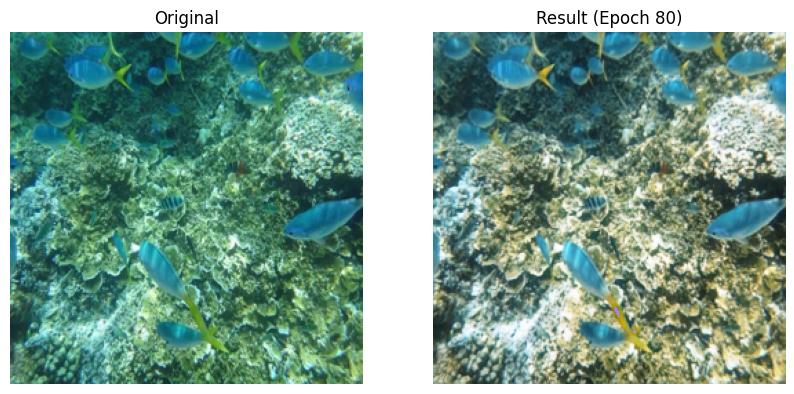


--- Running Quantitative Evaluation ---


Evaluating Epoch 80: 100%|██████████| 89/89 [01:16<00:00,  1.16it/s]


--- Evaluation Complete ---
Results for Epoch 80:
Average PSNR:   16.74 dB (Higher is better)
Average SSIM:   0.7783 (Higher is better, max 1.0)
Average UCIQE:  24.0610 (Higher is better)
Average UIQM:   -196.9624 (Higher is better)


In [ ]:
# Cell 3: Evaluation Script with CORRECTED Metric Calculation

import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2 # Import OpenCV

# --- ⚠️ EDIT THIS VARIABLE TO CHOOSE THE CHECKPOINT ---
EPOCH_TO_TEST = 80
# ----------------------------------------------------

# --- Configuration ---
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Augmented_Checkpoints"
MODEL_FILENAME = f"augmented_model_epoch_{EPOCH_TO_TEST}.pth"
MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# --- Load Model and Run Evaluation ---
model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)

if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
else:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print(f"Successfully loaded: {MODEL_FILENAME}")

    # --- Visual Inference part remains the same ---
    # ... (omitted for brevity, you can keep your existing visual inference code here) ...
    print("\n--- Running Visual Inference ---")
    test_raw_dir = os.path.join(TEST_DATA_DIR, 'raw')
    sample_image_path = glob.glob(os.path.join(test_raw_dir, '*'))[5]
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    input_image = Image.open(sample_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        restored_tensor, _, _ = model(input_tensor)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE))); axes[0].set_title("Original"); axes[0].axis('off')
    restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())
    axes[1].imshow(restored_pil); axes[1].set_title(f"Result (Epoch {EPOCH_TO_TEST})"); axes[1].axis('off')
    plt.show()

    # --- Quantitative Evaluation with CORRECTED metric calculation ---
    print("\n--- Running Quantitative Evaluation ---")
    test_ref_dir = os.path.join(TEST_DATA_DIR, 'reference')
    test_files = sorted(glob.glob(os.path.join(test_raw_dir, '*')))

    psnr_scores, ssim_scores, uciqe_scores, uiqm_scores = [], [], [], []

    with torch.no_grad():
        for raw_file_path in tqdm(test_files, desc=f"Evaluating Epoch {EPOCH_TO_TEST}"):
            filename = os.path.basename(raw_file_path)
            ref_file_path = os.path.join(test_ref_dir, filename)
            raw_img = Image.open(raw_file_path).convert('RGB')
            ref_img = Image.open(ref_file_path).convert('RGB')
            input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)
            gt_tensor = transform(ref_img)

            restored_tensor, _, _ = model(input_tensor)

            # --- CALCULATE PSNR/SSIM (remains the same) ---
            restored_np_01 = np.transpose(restored_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))
            gt_np_01 = np.transpose(gt_tensor.numpy(), (1, 2, 0))
            restored_np_01, gt_np_01 = np.clip(restored_np_01, 0, 1), np.clip(gt_np_01, 0, 1)
            psnr_scores.append(psnr(gt_np_01, restored_np_01, data_range=1.0))
            ssim_scores.append(ssim(gt_np_01, restored_np_01, data_range=1.0, channel_axis=-1))

            # --- CORRECTED WAY TO CALCULATE UCIQE/UIQM ---
            # 1. Convert the output tensor to a PIL Image first. This is a safe intermediate format.
            restored_pil_img = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

            # 2. Convert the PIL Image to a NumPy array (it will be in uint8 [0,255] RGB format)
            restored_cv_rgb = np.array(restored_pil_img)

            # 3. The metric functions expect RGB, so no need to convert to BGR here.
            uciqe_scores.append(uciqe(restored_cv_rgb))
            uiqm_scores.append(uiqm(restored_cv_rgb))

    # Calculate and print averages
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_uciqe = np.mean(uciqe_scores)
    avg_uiqm = np.mean(uiqm_scores)

    print("\n--- Evaluation Complete ---")
    print(f"Results ")
    print(f"Average PSNR:   {avg_psnr:.2f} dB (Higher is better)")
    print(f"Average SSIM:   {avg_ssim:.4f} (Higher is better, max 1.0)")
    print(f"Average UCIQE:  {avg_uciqe:.4f} (Higher is better)")
    print(f"Average UIQM:   {avg_uiqm:.4f} (Higher is better)")

In [ ]:
# Cell to Enhance and Save all Test Images

import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import glob

# Ensure the model architecture is defined in your notebook
# If not, you'll need to run the cell that defines AquaMorphicUNet first.

# --- Configuration ---
# Load your best performing model
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Augmented_Checkpoints"
MODEL_FILENAME = "augmented_model_epoch_70.pth" # Using epoch 70 as it had the best SSIM
MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

# Source of images to enhance
TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test/raw"

# Destination folder for the enhanced images
# Let's create a new folder for this
ENHANCED_IMAGE_DIR = "/content/drive/My Drive/UIEB_ENHANCED_RESULTS"
os.makedirs(ENHANCED_IMAGE_DIR, exist_ok=True)

IMAGE_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load Model ---
model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"Model '{MODEL_FILENAME}' loaded successfully.")

# --- Define Transform ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# --- Processing Loop ---
test_files = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '*')))
print(f"Found {len(test_files)} images to enhance and save...")

with torch.no_grad():
    for raw_file_path in tqdm(test_files, desc="Enhancing and Saving Images"):
        filename = os.path.basename(raw_file_path)

        # Load and transform the image
        raw_img = Image.open(raw_file_path).convert('RGB')
        input_tensor = transform(raw_img).unsqueeze(0).to(DEVICE)

        # Run inference
        restored_tensor, _, _ = model(input_tensor)

        # Convert output tensor to a PIL Image
        restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        # Define the save path and save the image
        save_path = os.path.join(ENHANCED_IMAGE_DIR, filename)
        restored_pil.save(save_path)

print(f"\nEnhancement complete. All {len(test_files)} images are saved in:")
print(ENHANCED_IMAGE_DIR)

Model 'augmented_model_epoch_70.pth' loaded successfully.
Found 89 images to enhance and save...


Enhancing and Saving Images: 100%|██████████| 89/89 [00:08<00:00, 10.17it/s]


Enhancement complete. All 89 images are saved in:
/content/drive/My Drive/UIEB_ENHANCED_RESULTS


In [ ]:
# 📌 Install dependencies
!pip install numpy opencv-python scikit-image scipy

import os
import cv2
import numpy as np
from skimage import color
from scipy import ndimage
from google.colab import drive

# -------------------------------
# MOUNT GOOGLE DRIVE
# -------------------------------
# drive.mount('/content/drive')

# -------------------------------
# UCIQE IMPLEMENTATION
# -------------------------------
def compute_uciqe(img_rgb):
    if img_rgb.dtype == np.uint8:
        img = img_rgb.astype('float32') / 255.0
    else:
        img = np.clip(img_rgb, 0.0, 1.0).astype('float32')

    lab = color.rgb2lab(img)
    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

    chroma = np.sqrt(a ** 2 + b ** 2)
    sigma_c = np.std(chroma)
    con_l = np.percentile(L, 99) - np.percentile(L, 1)
    mu_s = np.mean(chroma / (L + 1e-8))

    c1, c2, c3 = 0.4680, 0.2745, 0.2576
    return float(c1 * sigma_c + c2 * con_l + c3 * mu_s)

# -------------------------------
# UIQM IMPLEMENTATION
# -------------------------------
def UICM_colorfulness(img_rgb):
    R, G, B = img_rgb[..., 0].astype(np.float64), img_rgb[..., 1].astype(np.float64), img_rgb[..., 2].astype(np.float64)
    rg = R - G
    yb = 0.5 * (R + G) - B
    std_rg, std_yb = np.std(rg), np.std(yb)
    mean_rg, mean_yb = np.mean(rg), np.mean(yb)
    return np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)

def UISM_sharpness(img_gray):
    lap = ndimage.laplace(img_gray.astype(np.float64))
    return np.mean(np.abs(lap))

def UIConM_contrast(img_gray):
    return np.std(img_gray.astype(np.float64))

def compute_uiqm(img_rgb):
    if img_rgb.dtype == np.uint8:
        img = img_rgb.astype(np.float64)
    else:
        img = np.clip(img_rgb, 0.0, 255.0).astype(np.float64)

    img_gray = color.rgb2gray(img / 255.0)
    UICM = UICM_colorfulness(img)
    UISM = UISM_sharpness(img_gray)
    UIConM = UIConM_contrast(img_gray)

    a, b, c = 0.0282, 0.2953, 3.5753
    return float(a * UICM + b * UISM + c * UIConM)

# -------------------------------
# EVALUATE ALL IMAGES IN FOLDER
# -------------------------------
def evaluate_folder(folder):
    results = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif')):
            path = os.path.join(folder, fname)
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

            uciqe = compute_uciqe(img)
            uiqm = compute_uiqm(img)

            print(f"{fname:25s} | UCIQE={uciqe:.4f} | UIQM={uiqm:.4f}")
            results.append([uciqe, uiqm])

    results = np.array(results)
    mean_uciqe, std_uciqe = results[:,0].mean(), results[:,0].std()
    mean_uiqm, std_uiqm = results[:,1].mean(), results[:,1].std()

    print("\n--- Dataset-level stats ---")
    print(f"UCIQE: mean={mean_uciqe:.4f}, std={std_uciqe:.4f}")
    print(f"UIQM : mean={mean_uiqm:.4f}, std={std_uiqm:.4f}")

# -------------------------------
# RUN (set your image folder path here)
# -------------------------------
image_folder = "/content/drive/My Drive/UIEB_ENHANCED_RESULTS"  # 👈 change this to your folder
evaluate_folder(image_folder)


107_img_.png              | UCIQE=25.6012 | UIQM=3.5200
12324.png                 | UCIQE=42.9094 | UIQM=3.5591
12422.png                 | UCIQE=22.4393 | UIQM=1.7320
12445.png                 | UCIQE=26.8134 | UIQM=1.4918
133_img_.png              | UCIQE=17.6173 | UIQM=1.3499
139_img_.png              | UCIQE=17.0772 | UIQM=2.5129
13_img_.png               | UCIQE=17.6344 | UIQM=2.3071
143_img_.png              | UCIQE=20.4170 | UIQM=2.1861
149_img_.png              | UCIQE=33.8121 | UIQM=3.5030
15_img_.png               | UCIQE=31.3083 | UIQM=2.8898
160_img_.png              | UCIQE=17.1589 | UIQM=2.2484
172_img_.png              | UCIQE=21.1244 | UIQM=1.5725
186_img_.png              | UCIQE=29.4853 | UIQM=2.2681
19_img_.png               | UCIQE=34.8854 | UIQM=3.5526
203_img_.png              | UCIQE=27.2062 | UIQM=2.5470
207_img_.png              | UCIQE=26.3194 | UIQM=1.8440
216_img_.png              | UCIQE=23.7574 | UIQM=1.6904
217_img_.png              | UCIQE=18.0519 | UIQM

Successfully loaded: augmented_model_epoch_70.pth

--- Running Visual Inference ---
Using test image: 497_img_.png


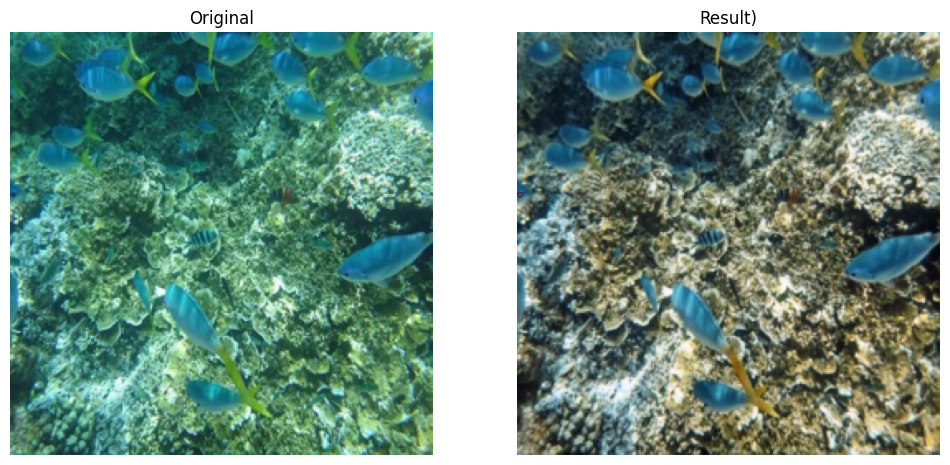


Visual inference complete.


In [ ]:
# Cell for Visual Inference Only (Original vs. Enhanced)

import torch
from torchvision import transforms
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

# Make sure the AquaMorphicUNet class is defined in a previous cell.
# If you get a "NameError", run the cell that defines the model architecture first.

# --- ⚠️ EDIT THIS VARIABLE TO CHOOSE THE CHECKPOINT ---
EPOCH_TO_TEST = 70
# You can change this to 10, 20, 30, 40, 50, 60, 70, or 80 to test different models.
# ----------------------------------------------------

# --- Configuration ---
CHECKPOINT_DIR = "/content/drive/My Drive/AquaMorphic_Augmented_Checkpoints"
MODEL_FILENAME = f"augmented_model_epoch_{EPOCH_TO_TEST}.pth"
MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)

TEST_DATA_DIR = "/content/drive/My Drive/UIEB_SPLIT/test"
IMAGE_SIZE = 256 # Match the training image size
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# --- Load Model and Run Evaluation ---
try:
    model = AquaMorphicUNet(n_channels=3, n_classes=3).to(DEVICE)

    if not os.path.exists(MODEL_PATH):
        print(f"ERROR: Model file not found at {MODEL_PATH}")
        print("Please check that the checkpoint for the specified epoch has been saved.")
    else:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.eval()
        print(f"Successfully loaded: {MODEL_FILENAME}")

        # --- Visual Inference on a sample image ---
        print("\n--- Running Visual Inference ---")
        test_raw_dir = os.path.join(TEST_DATA_DIR, 'raw')

        # You can change the number in the brackets to pick a different test image, e.g., [0], [1], etc.
        sample_image_path = "/content/drive/MyDrive/UIEB_SPLIT/test/raw/160_img_.png"#glob.glob(os.path.join(test_raw_dir, '*'))[5]
        print(f"Using test image: {os.path.basename(sample_image_path)}")

        transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
        input_image = Image.open(sample_image_path).convert('RGB')
        input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor, _, _ = model(input_tensor)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(input_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
        axes[0].set_title("Original")
        axes[0].axis('off')

        restored_pil = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())
        axes[1].imshow(restored_pil)
        axes[1].set_title(f"Result)")
        axes[1].axis('off')

        plt.show()
        print("\nVisual inference complete.")

except NameError:
    print("ERROR: 'AquaMorphicUNet' is not defined.")
    print("Please run the cell that contains the model's class definition first.")